In [2]:
import os
import hashlib

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def list_files(datadir, hash_dict):
    for data_type in ['Training', 'Testing']:
        data_type_path = os.path.join(datadir, data_type)
        print(data_type_path)
        if os.path.exists(data_type_path):
            labels = [d for d in os.listdir(data_type_path) if os.path.isdir(os.path.join(data_type_path, d))]
            for label in labels:
                folder_path = os.path.join(data_type_path, label)
                for root, dirs, files in os.walk(folder_path):
                    for file in files:
                        if file.endswith(".jpg"):
                            file_path = os.path.join(root, file)
                            file_hash = compute_hash(file_path)
                            if file_hash in hash_dict:
                                hash_dict[file_hash].append(file_path)
                            else:
                                hash_dict[file_hash] = [file_path]

def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash: {hash_value}): {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates removed: {duplicate_count}")


datadir = "./archive_new/"
hash_dict = {}
list_files(datadir, hash_dict)
remove_duplicates(hash_dict)


./archive_new/Training
./archive_new/Testing
Number of duplicates removed: 0


In [3]:
# we have removed duplicates from the dataset, we should check the distribution of the dataset
# and make sure that the dataset is balanced

def check_distribution(datadir):
    for data_type in ['Training', 'Testing']:
        data_type_path = os.path.join(datadir, data_type)
        print(data_type_path)
        if os.path.exists(data_type_path):
            labels = [d for d in os.listdir(data_type_path) if os.path.isdir(os.path.join(data_type_path, d))]
            for label in labels:
                folder_path = os.path.join(data_type_path, label)
                num_files = len([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
                print(f"{label}: {num_files}")

check_distribution(datadir)

./archive_new/Training
notumor: 1422
pituitary: 1445
meningioma: 1333
glioma: 1321
./archive_new/Testing
notumor: 309
pituitary: 295
meningioma: 302
glioma: 299


seems like we're good to go

In [1]:
# import the necessary libraries
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset

# import dataloader class
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.models import efficientnet_b0

# import visualisation tool
import matplotlib.pyplot as plt
import seaborn as sns

# import time to time the training
import time

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
torch.cuda.is_available()

True

In [2]:
# load in the data
data_dir = "./archive_new/"
train_dir = data_dir + 'Training'
test_dir = data_dir + 'Testing'

# define the transforms for the training and testing data
data_transforms = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# load the data
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
test_data = datasets.ImageFolder(test_dir, transform=data_transforms)

# define the dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [3]:
if torch.cuda.is_available():
    print("Training on GPU, moving data to GPU...")
    device = torch.device('cuda')
    train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
    # test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

Training on GPU, moving data to GPU...


In [8]:
# load in the pretrained model
model_pretrained = efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

# freeze the weights of the model
for param in model_pretrained.parameters():
    param.requires_grad = False

# unfreeze the last layer
for param in model_pretrained.classifier.parameters():
    param.requires_grad = True

# define the new classifier
model_pretrained.classifier = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4),
    nn.LogSoftmax(dim=1)
)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)

In [9]:
# train the model for 10 epochs
epochs = 10
start = time.time()
train_start = start
train_loc = train_loader_gpu if torch.cuda.is_available() else train_loader
if torch.cuda.is_available():
    model_pretrained.to(device)
    
for epoch in range(epochs):
    model_pretrained.train()
    running_loss = 0.0
    for data, target in train_loc:
        optimizer.zero_grad()
        output = model_pretrained(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()} performed in {time.time() - start} seconds')
    start = time.time()
print(f'Training performed in {time.time() - train_start} seconds')

/home/adam/.conda/envs/torch/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Loss: 0.33709168434143066 performed in 9.380393743515015 seconds
Epoch 2, Loss: 0.4960719347000122 performed in 9.141579866409302 seconds
Epoch 3, Loss: 0.11000063270330429 performed in 9.954923152923584 seconds
Epoch 4, Loss: 0.06429319083690643 performed in 10.7223060131073 seconds
Epoch 5, Loss: 0.08843201398849487 performed in 10.748022317886353 seconds
Epoch 6, Loss: 0.07383351027965546 performed in 10.748276233673096 seconds
Epoch 7, Loss: 0.046386364847421646 performed in 10.746000289916992 seconds
Epoch 8, Loss: 0.12887144088745117 performed in 10.745153903961182 seconds
Epoch 9, Loss: 0.015702249482274055 performed in 10.74558973312378 seconds
Epoch 10, Loss: 0.0231036264449358 performed in 10.742873191833496 seconds
Training performed in 103.67584490776062 seconds


In [10]:
# evaluate the model with loss and accuracy
model_pretrained.eval()
correct = 0
total = 0
loss = 0

test_temp = test_loader_gpu if torch.cuda.is_available() else test_loader
with torch.no_grad():
    for data, target in test_temp:
        output = model_pretrained(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Loss: {loss / len(test_loader)}')
print(f'Accuracy: {correct / total}')

Loss: 0.13109365821276842
Accuracy: 0.9477178423236514


Text(50.72222222222221, 0.5, 'Actual')

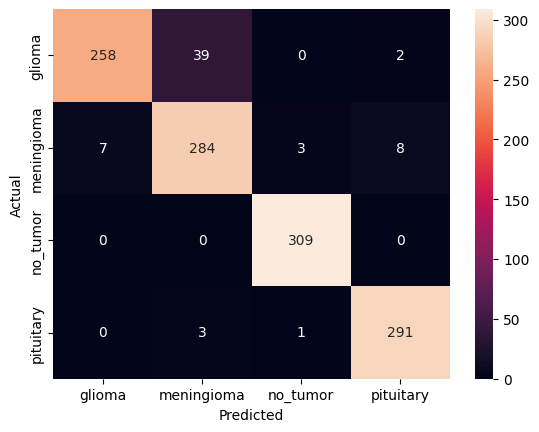

In [11]:
# plot the confusion matrix
confusion_matrix = torch.zeros(4, 4)
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)

# set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [12]:
# save the model
torch.save(model_pretrained.state_dict(), 'model_effnetb0.pth')

# save the model class
torch.save(model_pretrained, 'model_effnetb0_class.pth')

In [13]:
from sklearn.metrics import classification_report

# get the classification report
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.97      0.86      0.91       299
  meningioma       0.87      0.94      0.90       302
    no_tumor       0.99      1.00      0.99       309
   pituitary       0.97      0.99      0.98       295

    accuracy                           0.95      1205
   macro avg       0.95      0.95      0.95      1205
weighted avg       0.95      0.95      0.95      1205



In [4]:
# try again on a simple CNN

# define the model
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(128 * 32 * 32, 500),
    nn.ReLU(),
    nn.Linear(500, 4),
    nn.LogSoftmax(dim=1)
)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model.to(device)

In [5]:
# train the model for 10 epochs
epochs = 10
start = time.time()
train_start = start
train_loc = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loc:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()} performed in {time.time() - start} seconds')
    start = time.time()
print(f'Training performed in {time.time() - train_start} seconds')

/home/adam/.conda/envs/torch/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Loss: 0.4671344459056854 performed in 8.833163738250732 seconds
Epoch 2, Loss: 0.2510101795196533 performed in 9.587755918502808 seconds
Epoch 3, Loss: 0.14480839669704437 performed in 9.87868857383728 seconds
Epoch 4, Loss: 0.032033521682024 performed in 9.86344313621521 seconds
Epoch 5, Loss: 0.05090349167585373 performed in 9.868990421295166 seconds
Epoch 6, Loss: 0.008794909343123436 performed in 9.876316547393799 seconds
Epoch 7, Loss: 0.007442107889801264 performed in 9.877366542816162 seconds
Epoch 8, Loss: 0.02838791348040104 performed in 9.877375602722168 seconds
Epoch 9, Loss: 0.0006604963564313948 performed in 9.873881816864014 seconds
Epoch 10, Loss: 0.00011370704305591062 performed in 9.87374758720398 seconds
Training performed in 97.4113917350769 seconds


In [6]:
# save the model
torch.save(model.state_dict(), 'model_cnn.pth')

# save the model class
torch.save(model, 'model_cnn_class.pth')

In [10]:
# evaluate the model with loss and accuracy
model.eval()
model.cpu()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Loss: {loss / len(test_loader)}')
print(f'Accuracy: {correct / total}')


Loss: 0.23813987726737795
Accuracy: 0.9518672199170124


<Axes: >

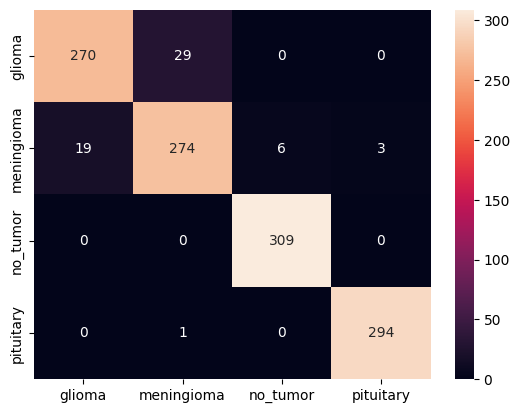

In [11]:
# confusion matrix
confusion_matrix = torch.zeros(4, 4)
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)


In [14]:
from sklearn.metrics import classification_report

# create classification report
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

      glioma       0.93      0.90      0.92       299
  meningioma       0.90      0.91      0.90       302
    no_tumor       0.98      1.00      0.99       309
   pituitary       0.99      1.00      0.99       295

    accuracy                           0.95      1205
   macro avg       0.95      0.95      0.95      1205
weighted avg       0.95      0.95      0.95      1205

